In [80]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import time
import pickle
import os

# Configuración para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Configuración para visualizaciones
plt.style.use('ggplot')
sns.set(font_scale=1.2)

In [81]:
# Función para evaluar el modelo en ambos conjuntos (entrenamiento y prueba)
def evaluar_modelo(modelo, X_train, y_train, X_test, y_test, nombre_modelo=""):
    """
    Evalúa el modelo en conjuntos de entrenamiento y prueba, y muestra métricas comparativas.
    
    Args:
        modelo: Modelo entrenado
        X_train: Características de entrenamiento
        y_train: Etiquetas de entrenamiento
        X_test: Características de prueba
        y_test: Etiquetas de prueba
        nombre_modelo: Nombre del modelo para mostrar en resultados
        
    Returns:
        dict: Diccionario con métricas de evaluación
    """
    # Evaluar en conjunto de entrenamiento
    y_pred_train = modelo.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train, average='weighted', zero_division=0)
    recall_train = recall_score(y_train, y_pred_train, average='weighted', zero_division=0)
    f1_train = f1_score(y_train, y_pred_train, average='weighted', zero_division=0)
    
    # Evaluar en conjunto de prueba
    y_pred_test = modelo.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
    recall_test = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
    f1_test = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
    
    # Calcular diferencias (para detectar sobreajuste)
    diff_accuracy = accuracy_train - accuracy_test
    diff_f1 = f1_train - f1_test
    
    print(f"\n===== EVALUACIÓN DEL MODELO: {nombre_modelo} =====")
    print("\nMétricas en conjunto de ENTRENAMIENTO:")
    print(f"  Accuracy:  {accuracy_train:.4f}")
    print(f"  Precision: {precision_train:.4f}")
    print(f"  Recall:    {recall_train:.4f}")
    print(f"  F1-Score:  {f1_train:.4f}")
    
    print("\nMétricas en conjunto de PRUEBA:")
    print(f"  Accuracy:  {accuracy_test:.4f}")
    print(f"  Precision: {precision_test:.4f}")
    print(f"  Recall:    {recall_test:.4f}")
    print(f"  F1-Score:  {f1_test:.4f}")
    
    print("\nDiferencia entre entrenamiento y prueba:")
    print(f"  Accuracy:  {diff_accuracy:.4f} ({diff_accuracy/accuracy_train*100:.1f}%)")
    print(f"  F1-Score:  {diff_f1:.4f} ({diff_f1/f1_train*100:.1f}%)")
    
    # Visualizar comparación
    plt.figure(figsize=(10, 6))
    metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    valores_train = [accuracy_train, precision_train, recall_train, f1_train]
    valores_test = [accuracy_test, precision_test, recall_test, f1_test]
    
    x = np.arange(len(metricas))
    width = 0.35
    
    plt.bar(x - width/2, valores_train, width, label='Entrenamiento', color='#3498db')
    plt.bar(x + width/2, valores_test, width, label='Prueba', color='#e74c3c')
    
    plt.xlabel('Métrica')
    plt.ylabel('Valor')
    plt.title(f'Comparación de métricas: {nombre_modelo}')
    plt.xticks(x, metricas)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Añadir valores sobre las barras
    for i, v in enumerate(valores_train):
        plt.text(i - width/2, v + 0.02, f'{v:.3f}', ha='center')
    
    for i, v in enumerate(valores_test):
        plt.text(i + width/2, v + 0.02, f'{v:.3f}', ha='center')
    
    plt.tight_layout()
    plt.savefig(f'comparacion_{nombre_modelo.replace(" ", "_").lower()}.png', dpi=300)
    plt.show()
    
    return {
        'train': {
            'accuracy': accuracy_train,
            'precision': precision_train,
            'recall': recall_train,
            'f1': f1_train
        },
        'test': {
            'accuracy': accuracy_test,
            'precision': precision_test,
            'recall': recall_test,
            'f1': f1_test
        },
        'diff': {
            'accuracy': diff_accuracy,
            'accuracy_pct': diff_accuracy/accuracy_train*100,
            'f1': diff_f1,
            'f1_pct': diff_f1/f1_train*100
        }
    }

# Función para visualizar matriz de confusión
def visualizar_confusion_matrix(y_true, y_pred, nombre_modelo=""):
    """
    Visualiza la matriz de confusión para el modelo.
    
    Args:
        y_true: Etiquetas reales
        y_pred: Etiquetas predichas
        nombre_modelo: Nombre del modelo para mostrar en resultados
    """
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    
    # Si hay muchas clases, mostrar solo las más frecuentes
    if len(np.unique(y_true)) > 20:
        # Encontrar las 15 clases más frecuentes
        class_counts = np.sum(cm, axis=1)
        top_classes_idx = np.argsort(class_counts)[-15:]
        cm_top = cm[top_classes_idx][:, top_classes_idx]
        
        # Normalizar la matriz
        cm_norm = cm_top.astype('float') / cm_top.sum(axis=1)[:, np.newaxis]
        cm_norm = np.nan_to_num(cm_norm)  # Manejar divisiones por cero
        
        # Crear etiquetas para las clases
        class_names = [f'Clase {i}' for i in top_classes_idx]
        
        # Visualizar matriz normalizada
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Matriz de Confusión Normalizada (Top 15 clases): {nombre_modelo}', fontsize=14)
    else:
        # Si hay pocas clases, mostrar todas
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_norm = np.nan_to_num(cm_norm)  # Manejar divisiones por cero
        
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
        plt.title(f'Matriz de Confusión Normalizada: {nombre_modelo}', fontsize=14)
    
    plt.xlabel('Predicción', fontsize=12)
    plt.ylabel('Valor Real', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{nombre_modelo.replace(" ", "_").lower()}.png', dpi=300)
    plt.show()

# Función para simplificar los GRD (eliminar el último dígito)
def simplificar_grd(grd_array):
    """
    Simplifica los códigos GRD eliminando el último dígito.
    
    Args:
        grd_array: Array con códigos GRD
        
    Returns:
        Array con códigos GRD simplificados
    """
    # Asegurarse de que todos los valores son strings
    grd_str = grd_array.astype(str)
    
    # Eliminar el último dígito
    grd_simple = np.array([grd[:-1] if len(grd) > 1 else grd for grd in grd_str])
    
    return grd_simple

# Función para extraer solo el código (parte antes del guión)
def extraer_codigo(texto):
    if pd.isna(texto) or texto == "":
        return ""
    
    # Extraer la parte antes del guión
    codigo = texto.split('-')[0].strip() if '-' in texto else texto
    return codigo

In [82]:
# Cargar el archivo CSV
print("Cargando datos desde archivo...")
try:
    df = pd.read_csv("dataset_elpino.csv", sep=";", encoding="utf-8")
    
    # Procesar los nombres de las columnas
    new_columns = []
    for col in df.columns:
        col_name = col.split("-")[0].strip()
        if col_name.startswith("Diag") or col_name.startswith("Proc"):
            parts = col_name.split(" ")
            if len(parts) > 1:
                col_name = parts[0] + parts[1]
        new_columns.append(col_name)
    
    df.columns = new_columns
    
    print("Datos cargados correctamente.")
    print(f"Dimensiones del DataFrame: {df.shape}")
    
    # Identificar columnas de diagnósticos y procedimientos
    cols_diag = [col for col in df.columns if col.startswith('Diag')]
    cols_proc = [col for col in df.columns if col.startswith('Proc')]
    
    print(f"Columnas de diagnósticos: {len(cols_diag)}")
    print(f"Columnas de procedimientos: {len(cols_proc)}")
    
except Exception as e:
    print(f"Error al cargar los datos: {e}")
    import traceback
    traceback.print_exc()

Cargando datos desde archivo...
Datos cargados correctamente.
Dimensiones del DataFrame: (14561, 68)
Columnas de diagnósticos: 35
Columnas de procedimientos: 30


Limpiando códigos GRD...
Se encontraron 144 filas duplicadas.
Filas después de eliminar duplicados: 14417

Resumen después de la limpieza:
Filas originales: 14561
Filas después de limpieza: 14417
Diferencia: 144

Número de GRD únicos: 526

Distribución de GRD después de la limpieza (top 10):
GRD
146101    811
146121    637
146131    538
134161    325
071141    317
044153    287
158171    271
061131    252
041023    248
146102    244
Name: count, dtype: int64


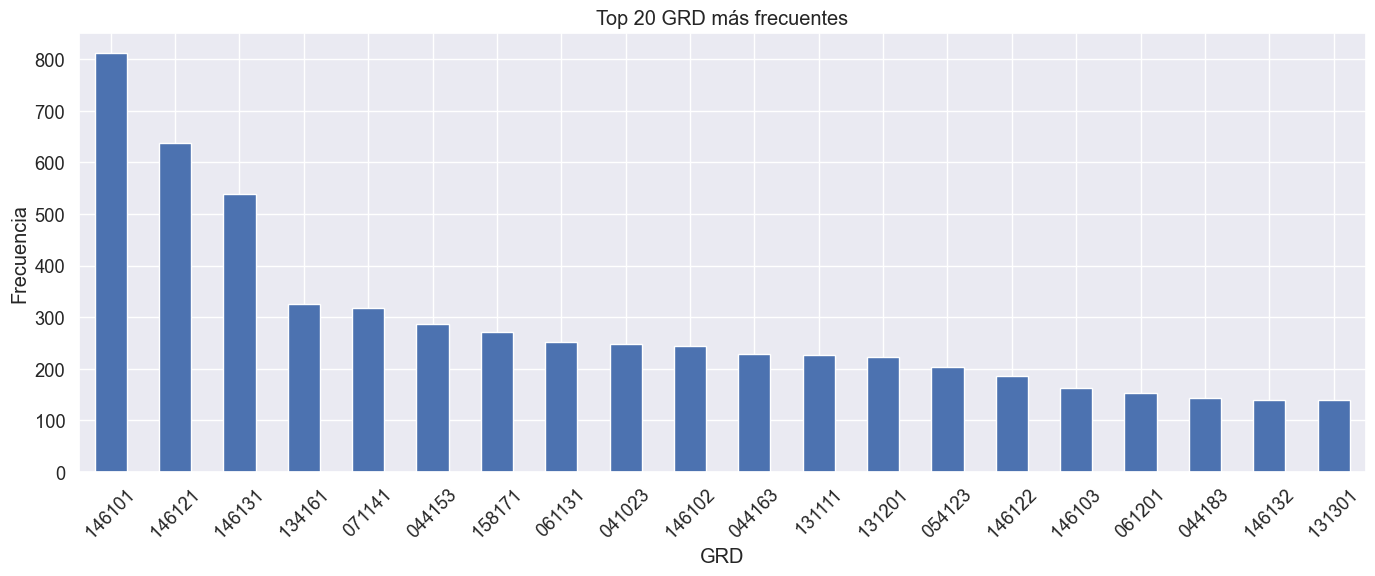


Ejemplos de GRD originales y limpios:
                                        GRD_original GRD_limpio
0                       184103 - MH SEPTICEMIA W/MCC     184103
1  041013 - PH ECMO VENTILACIÓN MECÁNICA PROLONGA...     041013
2  041013 - PH ECMO VENTILACIÓN MECÁNICA PROLONGA...     041013
3  041023 - PH VENTILACIÓN MECÁNICA PROLONGADA SI...     041023
4  041023 - PH VENTILACIÓN MECÁNICA PROLONGADA SI...     041023
5  041013 - PH ECMO VENTILACIÓN MECÁNICA PROLONGA...     041013
6  041013 - PH ECMO VENTILACIÓN MECÁNICA PROLONGA...     041013
7  041013 - PH ECMO VENTILACIÓN MECÁNICA PROLONGA...     041013
8  041023 - PH VENTILACIÓN MECÁNICA PROLONGADA SI...     041023
9  041023 - PH VENTILACIÓN MECÁNICA PROLONGADA SI...     041023


In [83]:
# Función para limpiar el DataFrame
def limpiar_dataframe(df):
    # Crear una copia para no modificar el original
    df_limpio = df.copy()
    
    # Verificar y manejar valores nulos en GRD
    if df_limpio['GRD'].isnull().sum() > 0:
        print(f"Se encontraron {df_limpio['GRD'].isnull().sum()} valores nulos en GRD.")
        # Eliminar filas con GRD nulo
        df_limpio = df_limpio.dropna(subset=['GRD'])
        print(f"Filas después de eliminar GRD nulos: {df_limpio.shape[0]}")
    
    # Limpiar códigos GRD - extraer solo la parte numérica
    print("Limpiando códigos GRD...")
    df_limpio['GRD_original'] = df_limpio['GRD']  # Guardar el original por si acaso
    
    # Extraer el código numérico al principio del GRD
    df_limpio['GRD'] = df_limpio['GRD'].str.extract(r'^(\d+)')
    
    # Verificar si hay valores nulos después de la extracción
    if df_limpio['GRD'].isnull().sum() > 0:
        print(f"ADVERTENCIA: {df_limpio['GRD'].isnull().sum()} códigos GRD no pudieron ser extraídos correctamente.")
        print("Ejemplos de GRD problemáticos:")
        problematicos = df_limpio[df_limpio['GRD'].isnull()]['GRD_original'].head(5).tolist()
        for p in problematicos:
            print(f"  - {p}")
        
        # Eliminar filas con GRD nulo después de la extracción
        df_limpio = df_limpio.dropna(subset=['GRD'])
        print(f"Filas después de eliminar GRD problemáticos: {df_limpio.shape[0]}")
    
    # Manejar valores nulos en diagnósticos y procedimientos
    # Reemplazar NaN con cadena vacía para facilitar el procesamiento
    for col in cols_diag + cols_proc:
        df_limpio[col] = df_limpio[col].fillna("")
    
    # Normalizar códigos
    # Convertir todos los códigos a mayúsculas
    for col in cols_diag + cols_proc:
        df_limpio[col] = df_limpio[col].str.upper()
    
    # Eliminar duplicados exactos
    duplicados = df_limpio.duplicated().sum()
    if duplicados > 0:
        print(f"Se encontraron {duplicados} filas duplicadas.")
        df_limpio = df_limpio.drop_duplicates()
        print(f"Filas después de eliminar duplicados: {df_limpio.shape[0]}")
    
    return df_limpio

# Aplicar limpieza
df_limpio = limpiar_dataframe(df)

# Verificar resultados de la limpieza
print("\nResumen después de la limpieza:")
print(f"Filas originales: {df.shape[0]}")
print(f"Filas después de limpieza: {df_limpio.shape[0]}")
print(f"Diferencia: {df.shape[0] - df_limpio.shape[0]}")

# Verificar valores únicos en GRD
n_grd = df_limpio['GRD'].nunique()
print(f"\nNúmero de GRD únicos: {n_grd}")

# Verificar distribución de GRD después de la limpieza
print("\nDistribución de GRD después de la limpieza (top 10):")
print(df_limpio['GRD'].value_counts().head(10))

# Visualizar la distribución de GRD
plt.figure(figsize=(14, 6))
df_limpio['GRD'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 GRD más frecuentes')
plt.xlabel('GRD')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('distribucion_grd_top20.png', dpi=300)
plt.show()

# Mostrar ejemplos de GRD originales y limpios
print("\nEjemplos de GRD originales y limpios:")
muestra_grd = pd.DataFrame({
    'GRD_original': df_limpio['GRD_original'].head(10),
    'GRD_limpio': df_limpio['GRD'].head(10)
})
print(muestra_grd)

Creando GRD simplificados (eliminando último dígito)...

Ejemplos de GRD originales y simplificados:
      GRD GRD_simple
0  184103      18410
1  041013      04101
2  041013      04101
3  041023      04102
4  041023      04102
5  041013      04101
6  041013      04101
7  041013      04101
8  041023      04102
9  041023      04102

Número de GRD originales únicos: 526
Número de GRD simplificados únicos: 210
Reducción de clases: 316 clases menos (60.08%)


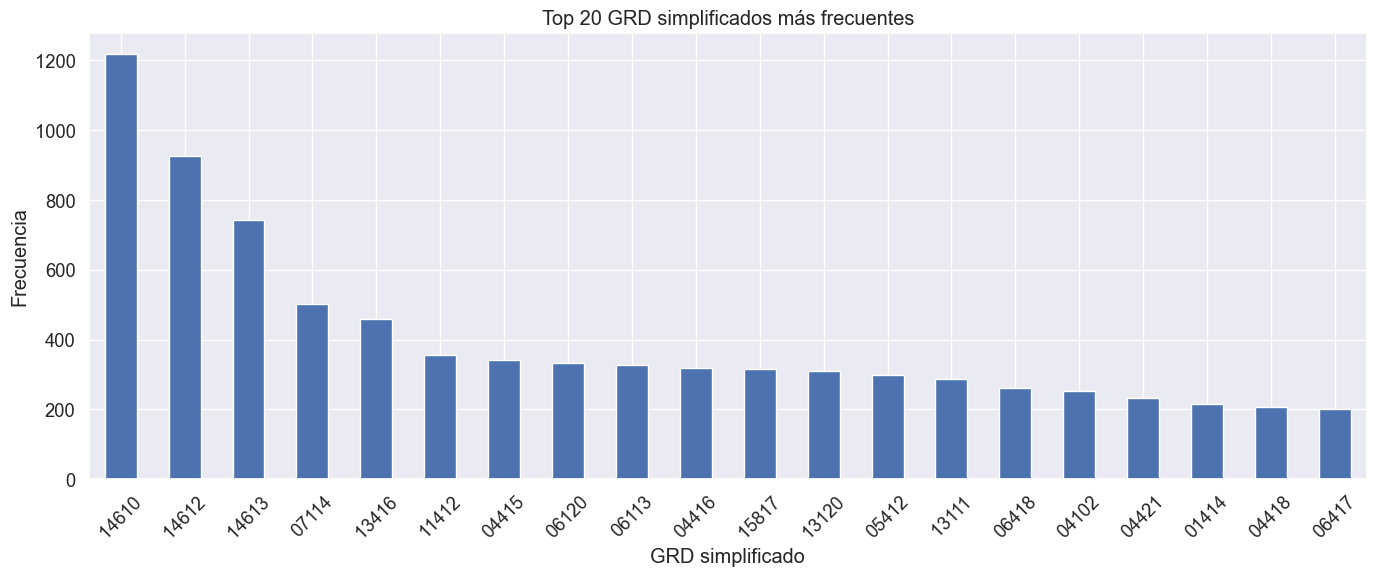

In [84]:
# Simplificar los códigos GRD (eliminar el último dígito)
print("Creando GRD simplificados (eliminando último dígito)...")
df_limpio['GRD_simple'] = simplificar_grd(df_limpio['GRD'])

# Verificar los resultados
print("\nEjemplos de GRD originales y simplificados:")
muestra = df_limpio[['GRD', 'GRD_simple']].head(10)
print(muestra)

# Contar clases únicas antes y después
n_grd_original = df_limpio['GRD'].nunique()
n_grd_simple = df_limpio['GRD_simple'].nunique()
reduccion = n_grd_original - n_grd_simple
porcentaje_reduccion = (reduccion / n_grd_original) * 100

print(f"\nNúmero de GRD originales únicos: {n_grd_original}")
print(f"Número de GRD simplificados únicos: {n_grd_simple}")
print(f"Reducción de clases: {reduccion} clases menos ({porcentaje_reduccion:.2f}%)")

# Visualizar distribución de GRD simplificados
plt.figure(figsize=(14, 6))
df_limpio['GRD_simple'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 GRD simplificados más frecuentes')
plt.xlabel('GRD simplificado')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('distribucion_grd_simple_top20.png', dpi=300)
plt.show()

Filtrando clases GRD_simple con frecuencia 3 o más...
Se encontraron 178 clases con frecuencia 3 o más
Se eliminarán 32 clases poco frecuentes

Resultados del filtrado:
  - Filas antes del filtrado: 14417
  - Filas después del filtrado: 14374
  - Filas eliminadas: 43 (0.30%)
  - Clases GRD_simple restantes: 178


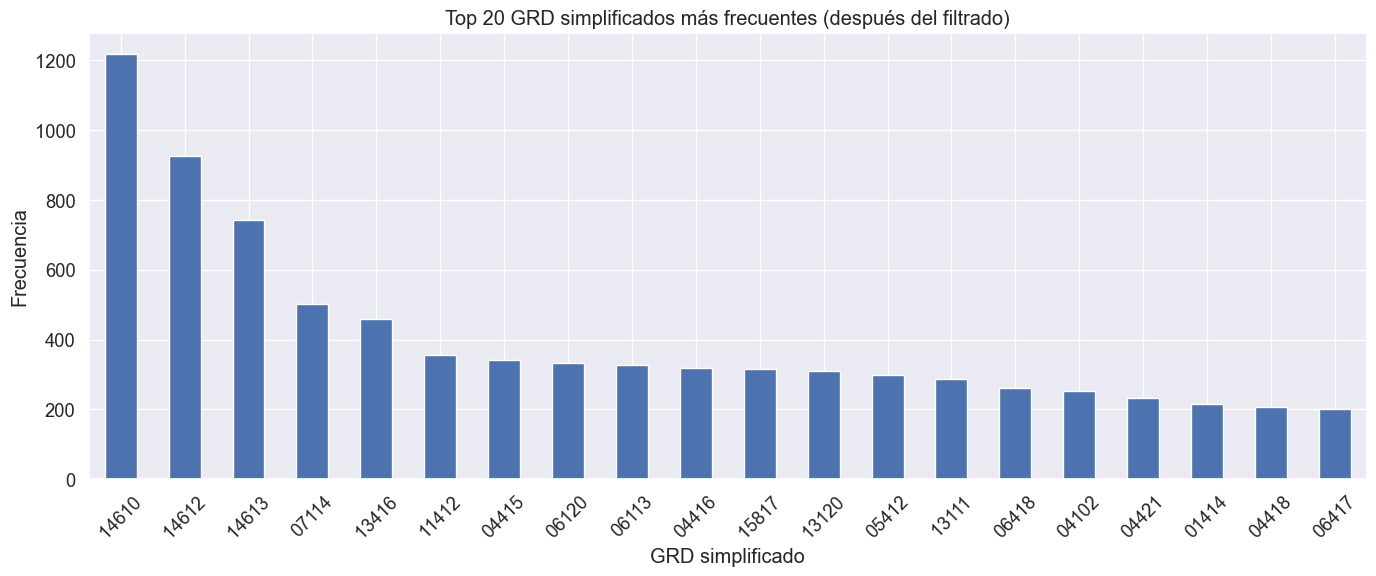

In [85]:
# Filtrar clases con frecuencia 3 o más
print("Filtrando clases GRD_simple con frecuencia 3 o más...")

# Contar frecuencia de cada clase GRD_simple
frecuencias_grd = df_limpio['GRD_simple'].value_counts()

# Identificar clases con frecuencia >= 3
clases_frecuentes = frecuencias_grd[frecuencias_grd >= 3].index.tolist()
print(f"Se encontraron {len(clases_frecuentes)} clases con frecuencia 3 o más")
print(f"Se eliminarán {len(frecuencias_grd) - len(clases_frecuentes)} clases poco frecuentes")

# Filtrar el DataFrame para mantener solo las clases frecuentes
df_filtrado = df_limpio[df_limpio['GRD_simple'].isin(clases_frecuentes)].copy()

# Verificar resultados del filtrado
filas_eliminadas = df_limpio.shape[0] - df_filtrado.shape[0]
porcentaje_eliminado = (filas_eliminadas / df_limpio.shape[0]) * 100

print(f"\nResultados del filtrado:")
print(f"  - Filas antes del filtrado: {df_limpio.shape[0]}")
print(f"  - Filas después del filtrado: {df_filtrado.shape[0]}")
print(f"  - Filas eliminadas: {filas_eliminadas} ({porcentaje_eliminado:.2f}%)")
print(f"  - Clases GRD_simple restantes: {df_filtrado['GRD_simple'].nunique()}")

# Actualizar df_limpio con el DataFrame filtrado
df_limpio = df_filtrado

# Visualizar distribución de GRD_simple después del filtrado
plt.figure(figsize=(14, 6))
df_limpio['GRD_simple'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 GRD simplificados más frecuentes (después del filtrado)')
plt.xlabel('GRD simplificado')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('distribucion_grd_simple_filtrado_top20.png', dpi=300)
plt.show()

In [86]:
# Limpiar códigos de diagnósticos y procedimientos
print("Limpiando códigos de diagnósticos y procedimientos...")

# Aplicar la limpieza a todas las columnas de diagnósticos y procedimientos
for col in cols_diag + cols_proc:
    df_limpio[f"{col}_original"] = df_limpio[col]  # Guardar original
    df_limpio[col] = df_limpio[col].apply(extraer_codigo)

# Verificar resultados de la limpieza
print("\nEjemplos de diagnósticos originales y limpios:")
muestra_diag = pd.DataFrame({
    'Original': df_limpio[f"{cols_diag[0]}_original"].head(5),
    'Limpio': df_limpio[cols_diag[0]].head(5)
})
print(muestra_diag)

print("\nEjemplos de procedimientos originales y limpios:")
muestra_proc = pd.DataFrame({
    'Original': df_limpio[f"{cols_proc[0]}_original"].head(5),
    'Limpio': df_limpio[cols_proc[0]].head(5)
})
print(muestra_proc)

# Verificar valores únicos en algunas columnas para confirmar la limpieza
print("\nNúmero de valores únicos en algunas columnas:")
for col in cols_diag[:3] + cols_proc[:3]:
    n_valores = df_limpio[col].nunique()
    print(f"{col}: {n_valores} valores únicos")

Limpiando códigos de diagnósticos y procedimientos...

Ejemplos de diagnósticos originales y limpios:
                                            Original Limpio
0            A41.8 - OTRAS SEPTICEMIAS ESPECIFICADAS  A41.8
1               U07.1 - COVID-19, VIRUS IDENTIFICADO  U07.1
2  K56.5 - ADHERENCIAS [BRIDAS] INTESTINALES CON ...  K56.5
3  K76.8 - OTRAS ENFERMEDADES ESPECIFICADAS DEL H...  K76.8
4  T81.0 - HEMORRAGIA Y HEMATOMA QUE COMPLICAN UN...  T81.0

Ejemplos de procedimientos originales y limpios:
                                            Original Limpio
0  86.28 - DESBRIDAMIENTO HERIDA,INFECCION O QUEM...  86.28
1                      31.1 - TRAQUEOSTOMIA TEMPORAL   31.1
2  86.22 - DESBRIDAMIENTO HERIDA,INFECCION O QUEM...  86.22
3                           54.19 - LAPAROTOMIA.OTRA  54.19
4                   54.11 - LAPAROTOMIA EXPLORATORIA  54.11

Número de valores únicos en algunas columnas:
Diag01: 1465 valores únicos
Diag02: 1703 valores únicos
Diag03: 1493 valores únic

C:\Users\cduty\AppData\Local\Temp\ipykernel_5716\3138109071.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_limpio[f"{col}_original"] = df_limpio[col]  # Guardar original
C:\Users\cduty\AppData\Local\Temp\ipykernel_5716\3138109071.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_limpio[f"{col}_original"] = df_limpio[col]  # Guardar original
C:\Users\cduty\AppData\Local\Temp\ipykernel_5716\3138109071.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

In [87]:
# Seleccionar solo las características requeridas
print("Seleccionando características específicas...")

# Seleccionar los primeros 10 diagnósticos y 18 procedimientos
cols_diag_seleccionados = cols_diag[:10]  # Primeros 10 diagnósticos
cols_proc_seleccionados = cols_proc[:18]  # Primeros 18 procedimientos

print(f"Diagnósticos seleccionados ({len(cols_diag_seleccionados)}):")
for i, col in enumerate(cols_diag_seleccionados):
    print(f"  {i+1}. {col}")

print(f"\nProcedimientos seleccionados ({len(cols_proc_seleccionados)}):")
for i, col in enumerate(cols_proc_seleccionados):
    print(f"  {i+1}. {col}")

# Seleccionar solo las columnas requeridas
columnas_seleccionadas = cols_diag_seleccionados + cols_proc_seleccionados
X_reducido = df_limpio[columnas_seleccionadas]
y_simple = df_limpio['GRD_simple']

print(f"\nDimensiones de X_reducido: {X_reducido.shape}")
print(f"Dimensiones de y_simple: {y_simple.shape}")

# Mostrar las primeras filas del conjunto de datos reducido
print("\nPrimeras filas del conjunto de datos reducido (con códigos limpios):")
print(X_reducido.head())

# Verificar valores únicos en algunas columnas para confirmar la limpieza
print("\nEjemplos de valores únicos en algunas columnas:")
for col in cols_diag_seleccionados[:3] + cols_proc_seleccionados[:3]:
    n_valores = X_reducido[col].nunique()
    valores_ejemplo = X_reducido[col].dropna().unique()[:5]  # Mostrar hasta 5 ejemplos
    print(f"{col}: {n_valores} valores únicos. Ejemplos: {valores_ejemplo}")

Seleccionando características específicas...
Diagnósticos seleccionados (10):
  1. Diag01
  2. Diag02
  3. Diag03
  4. Diag04
  5. Diag05
  6. Diag06
  7. Diag07
  8. Diag08
  9. Diag09
  10. Diag10

Procedimientos seleccionados (18):
  1. Proced01
  2. Proced02
  3. Proced03
  4. Proced04
  5. Proced05
  6. Proced06
  7. Proced07
  8. Proced08
  9. Proced09
  10. Proced10
  11. Proced11
  12. Proced12
  13. Proced13
  14. Proced14
  15. Proced15
  16. Proced16
  17. Proced17
  18. Proced18

Dimensiones de X_reducido: (14374, 28)
Dimensiones de y_simple: (14374,)

Primeras filas del conjunto de datos reducido (con códigos limpios):
  Diag01 Diag02 Diag03  Diag04  Diag05  Diag06 Diag07  Diag08 Diag09 Diag10  \
0  A41.8  B37.6  I39.8     N10   B96.1   L89.9  L08.9   B96.2  A41.5  J86.9   
1  U07.1  J12.8  R06.0     R05   R50.9   Z29.0  Z01.7  J96.00  J94.2  J92.9   
2  K56.5  R57.2  R57.1     J80     Y95   J15.0  U82.2   B95.6  B96.8  B37.1   
3  K76.8  K66.1  N18.5   D64.9   E87.5   E87

Preparando datos para modelado...

Codificando variables categóricas...
Codificando 28 variables categóricas...
Dimensiones de X_reducido después de codificar categóricas: (14374, 15209)

Codificando la variable objetivo (GRD_simple)...
Número de clases únicas en GRD_simple: 178
Codificador de etiquetas guardado como 'label_encoder_simple_reducido.pkl'

Dividiendo datos en conjuntos de entrenamiento y prueba (estratificado)...
X_train_reducido: (11499, 15209), X_test_reducido: (2875, 15209)
y_train_simple: (11499,), y_test_simple: (2875,)

Normalizando características...
Scaler guardado como 'scaler_reducido.pkl'

Guardando datos procesados...
Datos procesados guardados como archivos .npy

Visualizando distribución de clases...


<Figure size 1200x600 with 0 Axes>

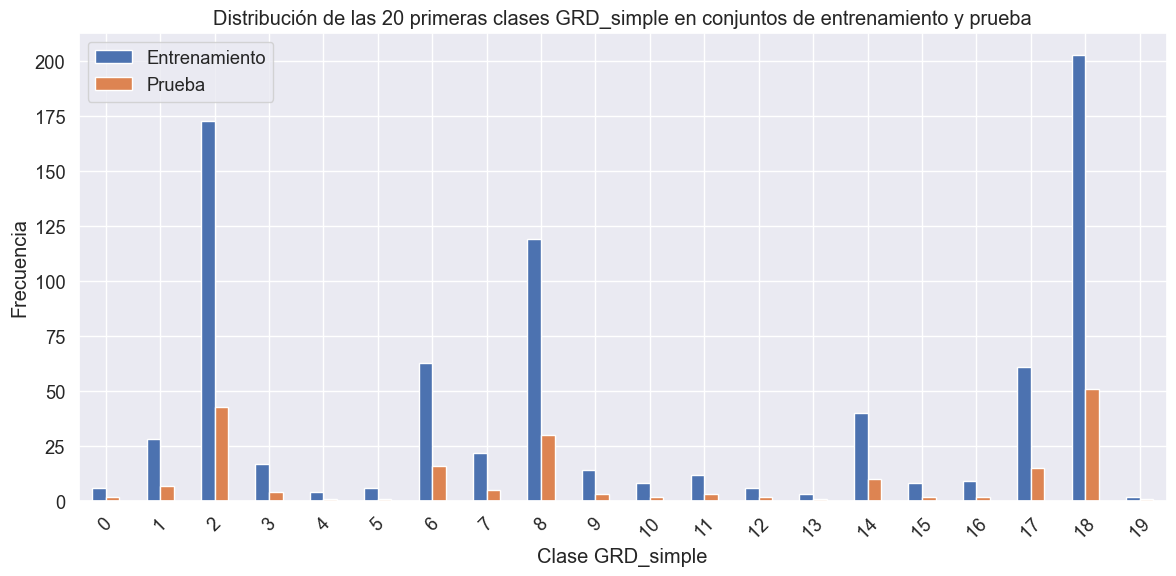


Preparación de datos completada con éxito.


In [88]:
# Preparación de datos para modelado
print("Preparando datos para modelado...")

# 1. Codificar variables categóricas
print("\nCodificando variables categóricas...")

# Identificar columnas categóricas
columnas_categoricas = X_reducido.select_dtypes(include=['object', 'category']).columns

if len(columnas_categoricas) > 0:
    print(f"Codificando {len(columnas_categoricas)} variables categóricas...")
    
    # Usar one-hot encoding para variables categóricas
    X_reducido = pd.get_dummies(X_reducido, columns=columnas_categoricas, drop_first=True)
    
    print(f"Dimensiones de X_reducido después de codificar categóricas: {X_reducido.shape}")

# 2. Codificar la variable objetivo (GRD_simple)
print("\nCodificando la variable objetivo (GRD_simple)...")

# Crear un codificador de etiquetas
label_encoder_simple = LabelEncoder()
y_simple_encoded = label_encoder_simple.fit_transform(y_simple)

print(f"Número de clases únicas en GRD_simple: {len(label_encoder_simple.classes_)}")

# Guardar el codificador para uso futuro
with open('label_encoder_simple_reducido.pkl', 'wb') as f:
    pickle.dump(label_encoder_simple, f)

print("Codificador de etiquetas guardado como 'label_encoder_simple_reducido.pkl'")

# 3. Dividir en conjuntos de entrenamiento y prueba (estratificado)
print("\nDividiendo datos en conjuntos de entrenamiento y prueba (estratificado)...")

X_train_reducido, X_test_reducido, y_train_simple, y_test_simple = train_test_split(
    X_reducido, y_simple_encoded, test_size=0.2, random_state=RANDOM_SEED, stratify=y_simple_encoded
)

print(f"X_train_reducido: {X_train_reducido.shape}, X_test_reducido: {X_test_reducido.shape}")
print(f"y_train_simple: {y_train_simple.shape}, y_test_simple: {y_test_simple.shape}")

# 4. Normalizar características
print("\nNormalizando características...")

scaler_reducido = StandardScaler()
X_train_reducido_scaled = scaler_reducido.fit_transform(X_train_reducido)
X_test_reducido_scaled = scaler_reducido.transform(X_test_reducido)

# Guardar el scaler para uso futuro
with open('scaler_reducido.pkl', 'wb') as f:
    pickle.dump(scaler_reducido, f)

print("Scaler guardado como 'scaler_reducido.pkl'")

# 5. Guardar datos procesados
print("\nGuardando datos procesados...")

np.save('X_train_reducido.npy', X_train_reducido_scaled)
np.save('X_test_reducido.npy', X_test_reducido_scaled)
np.save('y_train_simple_reducido.npy', y_train_simple)
np.save('y_test_simple_reducido.npy', y_test_simple)

print("Datos procesados guardados como archivos .npy")

# 6. Visualizar distribución de clases en conjuntos de entrenamiento y prueba
print("\nVisualizando distribución de clases...")

plt.figure(figsize=(12, 6))

# Contar frecuencias
train_counts = pd.Series(y_train_simple).value_counts().sort_index()
test_counts = pd.Series(y_test_simple).value_counts().sort_index()

# Tomar solo las 20 primeras clases para visualización
train_counts = train_counts.head(20)
test_counts = test_counts.head(20)

# Crear DataFrame para visualización
df_counts = pd.DataFrame({
    'Entrenamiento': train_counts,
    'Prueba': test_counts
})

# Visualizar
df_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Distribución de las 20 primeras clases GRD_simple en conjuntos de entrenamiento y prueba')
plt.xlabel('Clase GRD_simple')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('distribucion_clases_simple_reducido_train_test.png', dpi=300)
plt.show()

print("\nPreparación de datos completada con éxito.")

Entrenando Red Neuronal con conjunto de datos reducido...
Tiempo de entrenamiento: 283.83 segundos

===== EVALUACIÓN DEL MODELO: Red Neuronal (Conjunto Reducido) =====

Métricas en conjunto de ENTRENAMIENTO:
  Accuracy:  0.9989
  Precision: 0.9989
  Recall:    0.9989
  F1-Score:  0.9989

Métricas en conjunto de PRUEBA:
  Accuracy:  0.7969
  Precision: 0.7886
  Recall:    0.7969
  F1-Score:  0.7858

Diferencia entre entrenamiento y prueba:
  Accuracy:  0.2020 (20.2%)
  F1-Score:  0.2131 (21.3%)


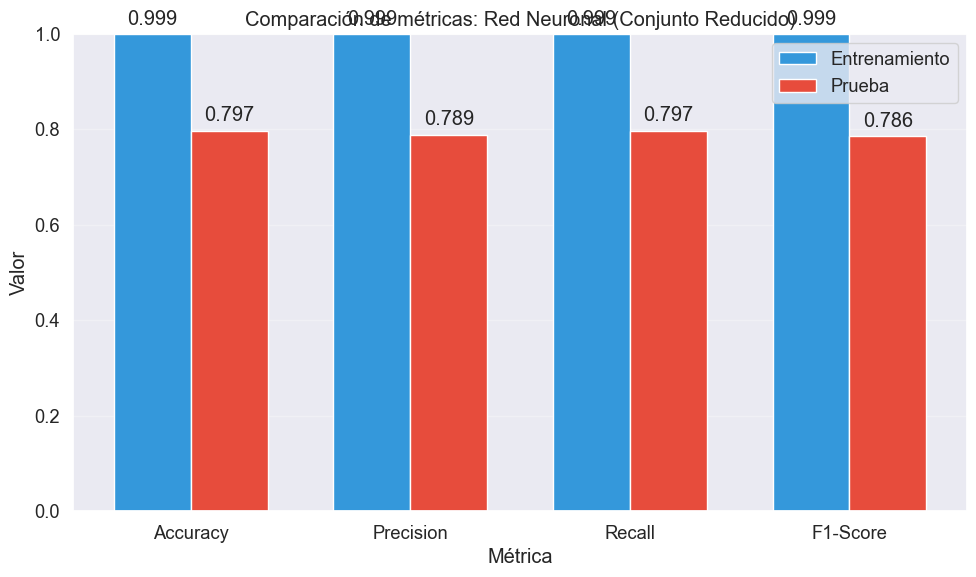


Analizando confusiones más comunes...

Las 15 confusiones más comunes:
Clase Real → Clase Predicha: Conteo
----------------------------------------
1. 04101 → 04102: 10
2. 04102 → 04415: 7
3. 04120 → 04102: 7
4. 15817 → 15813: 7
5. 14613 → 14612: 6
6. 15813 → 15817: 6
7. 14612 → 14613: 5
8. 15812 → 15813: 5
9. 05412 → 04102: 4
10. 07414 → 07114: 4
11. 04415 → 04102: 3
12. 05419 → 05410: 3
13. 06120 → 04102: 3
14. 06418 → 05412: 3
15. 07414 → 06418: 3


C:\Users\cduty\AppData\Local\Temp\ipykernel_5716\4229686280.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=labels, x=valores, palette='Reds_r')


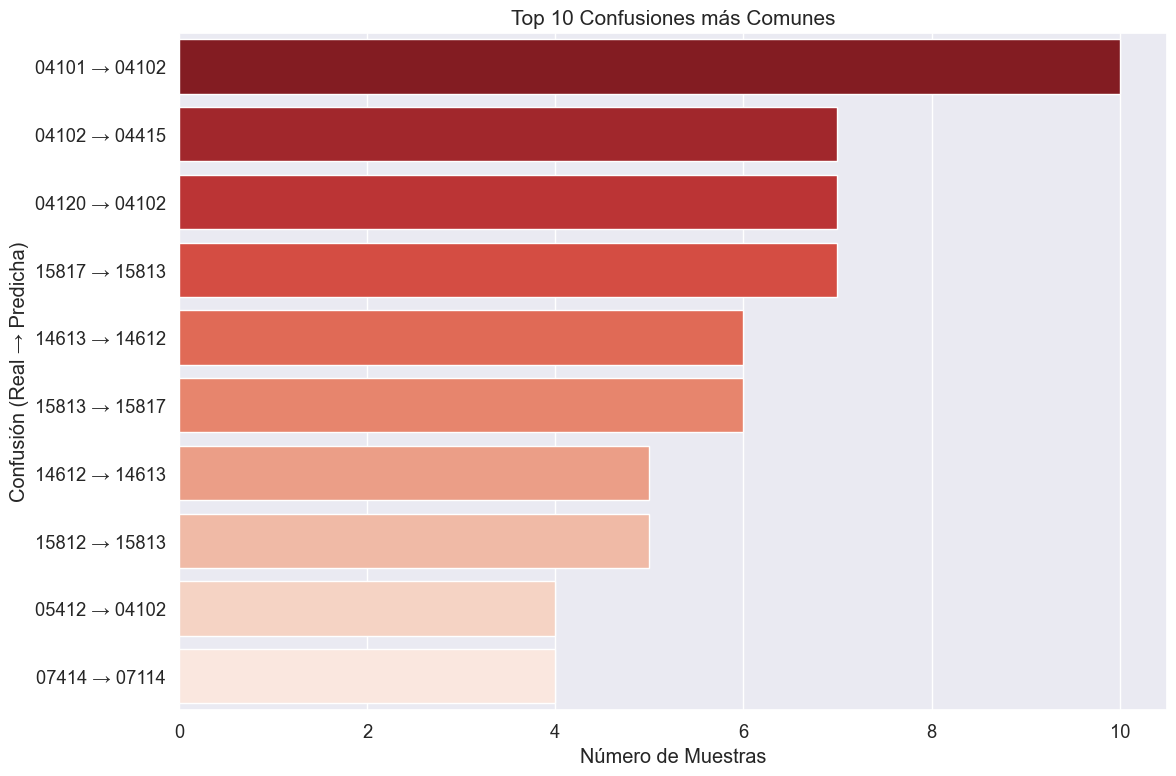


Clases más problemáticas (más confundidas con otras):

Top 10 clases más difíciles de predecir correctamente:
Clase: Total de confusiones
----------------------------------------
1. 06418: 23 (43.4% de error)
2. 04102: 22 (43.1% de error)
3. 04120: 18 (51.4% de error)
4. 15817: 15 (23.8% de error)
5. 15813: 13 (50.0% de error)
6. 04101: 12 (80.0% de error)
7. 11412: 12 (16.7% de error)
8. 05412: 11 (18.3% de error)
9. 04415: 11 (16.2% de error)
10. 18410: 10 (76.9% de error)

Modelo con conjunto reducido guardado como 'nn_reducido_model.pkl'


In [95]:
# Entrenar Red Neuronal con conjunto de datos reducido
print("Entrenando Red Neuronal con conjunto de datos reducido...")

# Crear y entrenar el modelo
nn_reducido = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=200,
    random_state=RANDOM_SEED
)

start_time = time.time()
nn_reducido.fit(X_train_reducido_scaled, y_train_simple)
training_time = time.time() - start_time

print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")

# Evaluar modelo con conjunto reducido
metricas_reducido = evaluar_modelo(
    nn_reducido, X_train_reducido_scaled, y_train_simple, 
    X_test_reducido_scaled, y_test_simple, 
    "Red Neuronal (Conjunto Reducido)"
)

# Obtener predicciones para el conjunto de prueba
y_pred_test_reducido = nn_reducido.predict(X_test_reducido_scaled)

# Análisis de confusiones más comunes
print("\nAnalizando confusiones más comunes...")
cm = confusion_matrix(y_test_simple, y_pred_test_reducido)

# Crear lista de confusiones (clase_real, clase_predicha, conteo)
confusiones = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j:  # Excluir la diagonal (predicciones correctas)
            confusiones.append((i, j, cm[i, j]))

# Ordenar por número de confusiones (descendente)
confusiones.sort(key=lambda x: x[2], reverse=True)

# Mostrar las 15 confusiones más comunes
print("\nLas 15 confusiones más comunes:")
print("Clase Real → Clase Predicha: Conteo")
print("-" * 40)

# Obtener nombres de clases reales
class_names = label_encoder_simple.classes_

for i, (real, pred, count) in enumerate(confusiones[:15]):
    if count > 0:  # Solo mostrar confusiones que ocurrieron
        print(f"{i+1}. {class_names[real]} → {class_names[pred]}: {count}")

# Visualizar las 10 confusiones más comunes
plt.figure(figsize=(12, 8))

# Preparar datos para visualización
top_confusiones = confusiones[:10]
labels = [f"{class_names[real]} → {class_names[pred]}" for real, pred, _ in top_confusiones]
valores = [count for _, _, count in top_confusiones]

# Crear gráfico de barras horizontales
sns.barplot(y=labels, x=valores, palette='Reds_r')
plt.title('Top 10 Confusiones más Comunes', fontsize=15)
plt.xlabel('Número de Muestras')
plt.ylabel('Confusión (Real → Predicha)')
plt.tight_layout()
plt.savefig('top_confusiones_modelo_reducido.png', dpi=300)
plt.show()

# Análisis de clases más problemáticas (más confundidas con otras)
print("\nClases más problemáticas (más confundidas con otras):")
clases_problematicas = {}

# Contar confusiones por clase real
for real, _, count in confusiones:
    if real not in clases_problematicas:
        clases_problematicas[real] = 0
    clases_problematicas[real] += count

# Ordenar por número total de confusiones
clases_ordenadas = sorted(clases_problematicas.items(), key=lambda x: x[1], reverse=True)

# Mostrar las 10 clases más problemáticas
print("\nTop 10 clases más difíciles de predecir correctamente:")
print("Clase: Total de confusiones")
print("-" * 40)
for i, (clase, total) in enumerate(clases_ordenadas[:10]):
    if total > 0:
        # Calcular el porcentaje de muestras mal clasificadas para esta clase
        total_muestras = np.sum(cm[clase])
        porcentaje_error = (total / total_muestras) * 100 if total_muestras > 0 else 0
        print(f"{i+1}. {class_names[clase]}: {total} ({porcentaje_error:.1f}% de error)")

# Guardar modelo reducido
with open('nn_reducido_model.pkl', 'wb') as f:
    pickle.dump({
        'modelo': nn_reducido,
        'metricas': metricas_reducido
    }, f)

print("\nModelo con conjunto reducido guardado como 'nn_reducido_model.pkl'")

In [96]:
# Comparación con el modelo base
print("Comparación con el modelo base:")

# Métricas del modelo base (proporcionadas por el usuario)
metricas_base = {
    'train': {
        'accuracy': 0.9237,
        'precision': 0.9295,
        'recall': 0.9237,
        'f1': 0.9228
    },
    'test': {
        'accuracy': 0.6283,
        'precision': 0.6210,
        'recall': 0.6283,
        'f1': 0.6142
    }
}

# Crear DataFrame para visualización
df_comparacion = pd.DataFrame([
    {
        'Modelo': 'Modelo Base (Train)',
        'Accuracy': metricas_base['train']['accuracy'],
        'Precision': metricas_base['train']['precision'],
        'Recall': metricas_base['train']['recall'],
        'F1-Score': metricas_base['train']['f1']
    },
    {
        'Modelo': 'Modelo Base (Test)',
        'Accuracy': metricas_base['test']['accuracy'],
        'Precision': metricas_base['test']['precision'],
        'Recall': metricas_base['test']['recall'],
        'F1-Score': metricas_base['test']['f1']
    },
    {
        'Modelo': 'Modelo Reducido (Train)',
        'Accuracy': metricas_reducido['train']['accuracy'],
        'Precision': metricas_reducido['train']['precision'],
        'Recall': metricas_reducido['train']['recall'],
        'F1-Score': metricas_reducido['train']['f1']
    },
    {
        'Modelo': 'Modelo Reducido (Test)',
        'Accuracy': metricas_reducido['test']['accuracy'],
        'Precision': metricas_reducido['test']['precision'],
        'Recall': metricas_reducido['test']['recall'],
        'F1-Score': metricas_reducido['test']['f1']
    }
])

# Mostrar tabla de comparación
print("\nTabla comparativa de métricas:")
print(df_comparacion)

# Calcular mejora respecto al modelo base (conjunto de prueba)
mejora_accuracy = metricas_reducido['test']['accuracy'] - metricas_base['test']['accuracy']
mejora_f1 = metricas_reducido['test']['f1'] - metricas_base['test']['f1']

print("\nMejora respecto al modelo base (conjunto de PRUEBA):")
print(f"  Accuracy: {mejora_accuracy:.4f} ({mejora_accuracy/metricas_base['test']['accuracy']*100:.1f}%)")
print(f"  F1-Score: {mejora_f1:.4f} ({mejora_f1/metricas_base['test']['f1']*100:.1f}%)")

# Comparar sobreajuste
diff_base = metricas_base['train']['f1'] - metricas_base['test']['f1']
diff_base_pct = diff_base / metricas_base['train']['f1'] * 100

diff_reducido = metricas_reducido['diff']['f1']
diff_reducido_pct = metricas_reducido['diff']['f1_pct']

print("\nComparación de sobreajuste (diferencia entre entrenamiento y prueba):")
print(f"  Modelo Base: {diff_base:.4f} ({diff_base_pct:.1f}%)")
print(f"  Modelo Reducido: {diff_reducido:.4f} ({diff_reducido_pct:.1f}%)")

Comparación con el modelo base:

Tabla comparativa de métricas:
                    Modelo  Accuracy  Precision    Recall  F1-Score
0      Modelo Base (Train)  0.923700   0.929500  0.923700  0.922800
1       Modelo Base (Test)  0.628300   0.621000  0.628300  0.614200
2  Modelo Reducido (Train)  0.998869   0.998882  0.998869  0.998870
3   Modelo Reducido (Test)  0.796870   0.788609  0.796870  0.785759

Mejora respecto al modelo base (conjunto de PRUEBA):
  Accuracy: 0.1686 (26.8%)
  F1-Score: 0.1716 (27.9%)

Comparación de sobreajuste (diferencia entre entrenamiento y prueba):
  Modelo Base: 0.3086 (33.4%)
  Modelo Reducido: 0.2131 (21.3%)


C:\Users\cduty\AppData\Local\Temp\ipykernel_5716\4153915784.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=modelos, y=f1_test, palette=['#9b59b6', '#2ecc71'])


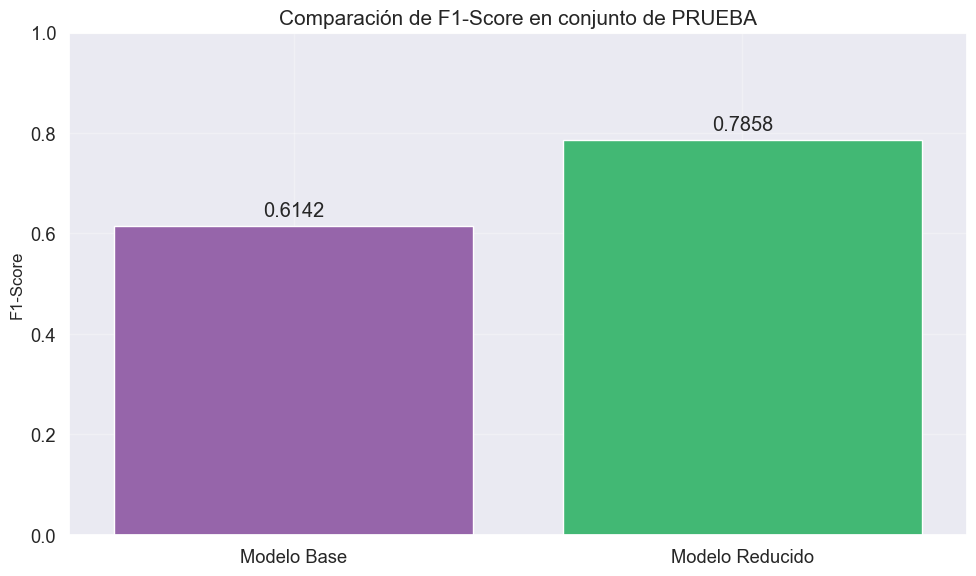

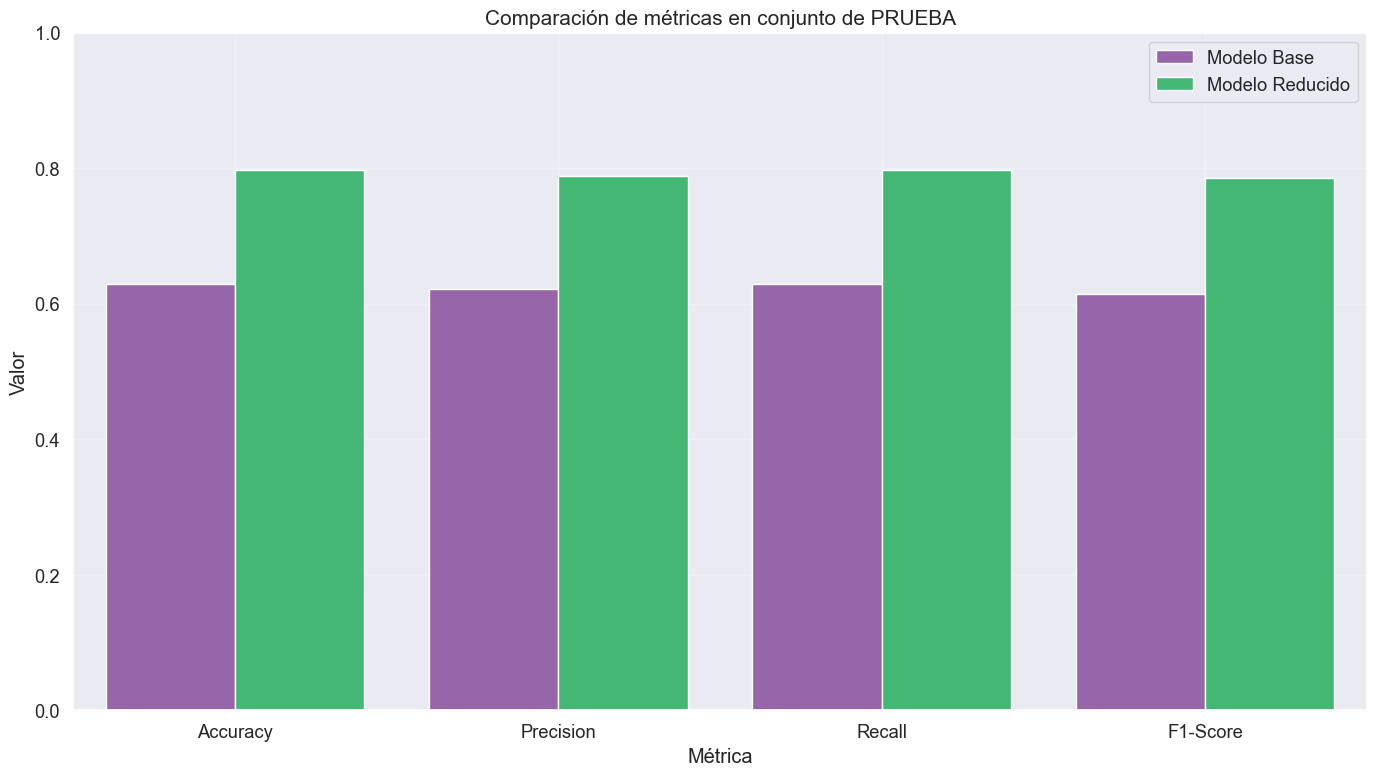

C:\Users\cduty\AppData\Local\Temp\ipykernel_5716\4153915784.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Accuracy', 'F1-Score'], y=mejoras_pct, palette='Greens')


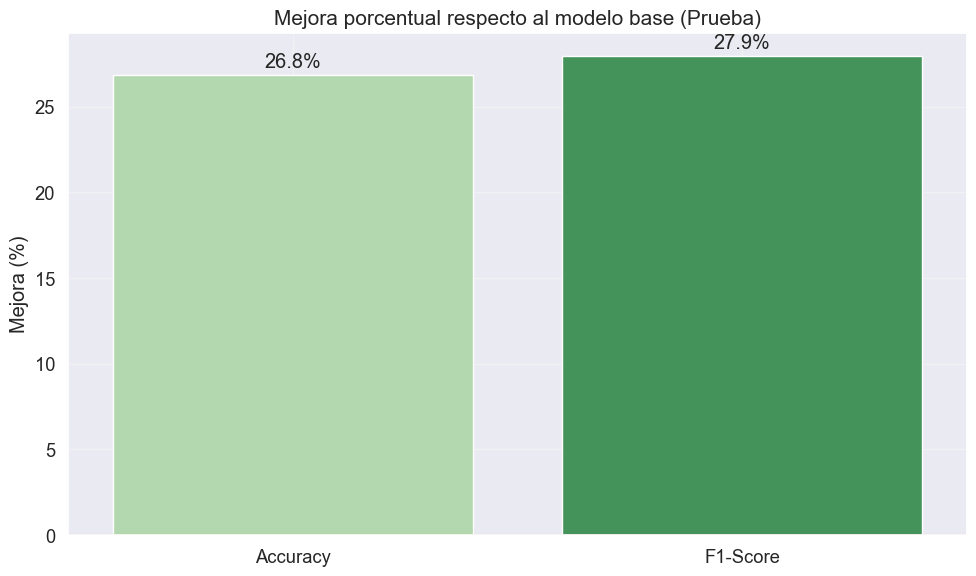

In [97]:
# Visualizar comparación de F1-Score en conjunto de prueba
plt.figure(figsize=(10, 6))

# Preparar datos para el gráfico
modelos = ['Modelo Base', 'Modelo Reducido']
f1_test = [metricas_base['test']['f1'], metricas_reducido['test']['f1']]

# Crear gráfico de barras
sns.barplot(x=modelos, y=f1_test, palette=['#9b59b6', '#2ecc71'])
plt.title('Comparación de F1-Score en conjunto de PRUEBA', fontsize=15)
plt.ylabel('F1-Score', fontsize=12)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# Añadir valores sobre las barras
for i, v in enumerate(f1_test):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.savefig('comparacion_f1_test_modelo_reducido.png', dpi=300)
plt.show()

# Visualizar comparación de todas las métricas en conjunto de prueba
plt.figure(figsize=(14, 8))

# Crear datos para gráfico
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
valores_base = [
    metricas_base['test']['accuracy'],
    metricas_base['test']['precision'],
    metricas_base['test']['recall'],
    metricas_base['test']['f1']
]
valores_reducido = [
    metricas_reducido['test']['accuracy'],
    metricas_reducido['test']['precision'],
    metricas_reducido['test']['recall'],
    metricas_reducido['test']['f1']
]

# Crear DataFrame en formato largo para seaborn
df_plot = pd.DataFrame({
    'Modelo': np.repeat(modelos, len(metricas)),
    'Métrica': np.tile(metricas, len(modelos)),
    'Valor': valores_base + valores_reducido
})

# Crear gráfico de barras agrupadas
sns.barplot(x='Métrica', y='Valor', hue='Modelo', data=df_plot, palette=['#9b59b6', '#2ecc71'])
plt.title('Comparación de métricas en conjunto de PRUEBA', fontsize=15)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend(title='')
plt.tight_layout()
plt.savefig('comparacion_metricas_test_modelo_reducido.png', dpi=300)
plt.show()

# Visualizar mejora porcentual respecto al modelo base
plt.figure(figsize=(10, 6))

# Preparar datos para el gráfico
mejoras_pct = [
    mejora_accuracy/metricas_base['test']['accuracy']*100,
    mejora_f1/metricas_base['test']['f1']*100
]

sns.barplot(x=['Accuracy', 'F1-Score'], y=mejoras_pct, palette='Greens')
plt.title('Mejora porcentual respecto al modelo base (Prueba)', fontsize=15)
plt.ylabel('Mejora (%)')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)

# Añadir valores sobre las barras
for i, v in enumerate(mejoras_pct):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.savefig('mejora_porcentual_modelo_reducido.png', dpi=300)
plt.show()

In [98]:
# Conclusiones y resumen
print("Resumen del análisis:")

# Crear un resumen de los resultados
resumen = {
    'Modelo Base': {
        'Accuracy (Train)': metricas_base['train']['accuracy'],
        'F1-Score (Train)': metricas_base['train']['f1'],
        'Accuracy (Test)': metricas_base['test']['accuracy'],
        'F1-Score (Test)': metricas_base['test']['f1'],
        'Diferencia F1 (%)': diff_base_pct
    },
    'Modelo Reducido': {
        'Accuracy (Train)': metricas_reducido['train']['accuracy'],
        'F1-Score (Train)': metricas_reducido['train']['f1'],
        'Accuracy (Test)': metricas_reducido['test']['accuracy'],
        'F1-Score (Test)': metricas_reducido['test']['f1'],
        'Diferencia F1 (%)': diff_reducido_pct
    },
    'Mejora': {
        'Accuracy (%)': mejora_accuracy/metricas_base['test']['accuracy']*100,
        'F1-Score (%)': mejora_f1/metricas_base['test']['f1']*100
    }
}

# Mostrar resumen
print("\nResumen de resultados:")
for modelo, metricas in resumen.items():
    print(f"\n{modelo}:")
    for metrica, valor in metricas.items():
        print(f"  {metrica}: {valor:.4f}")

# Guardar resumen
with open('resumen_resultados.pkl', 'wb') as f:
    pickle.dump(resumen, f)

print("\nResumen guardado como 'resumen_resultados.pkl'")

Resumen del análisis:

Resumen de resultados:

Modelo Base:
  Accuracy (Train): 0.9237
  F1-Score (Train): 0.9228
  Accuracy (Test): 0.6283
  F1-Score (Test): 0.6142
  Diferencia F1 (%): 33.4417

Modelo Reducido:
  Accuracy (Train): 0.9989
  F1-Score (Train): 0.9989
  Accuracy (Test): 0.7969
  F1-Score (Test): 0.7858
  Diferencia F1 (%): 21.3353

Mejora:
  Accuracy (%): 26.8295
  F1-Score (%): 27.9321

Resumen guardado como 'resumen_resultados.pkl'
